In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.util import ngrams  
from heapq import nlargest
import collections
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_confusion_matrix
import pickle 

In [2]:
data = pd.read_csv('pre_trained_data.csv', parse_dates=['timestamp'])
data.body.fillna('', inplace=True)
data.tail()

/var/folders/41/1lg2xxbj1dlcdf7gyq8_zr640000gn/T/ipykernel_52646/4286374791.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.body.fillna('', inplace=True)


,id,flair,title,body,comments,score,author,url,domain,comms_num,timestamp
190,1fxc8nz,Misc,What are some common household items that you ...,What is something that is so useful that you a...,Netherlands: Has a bathroom birthday calend...,348,HShatesme,https://www.reddit.com/r/AskEurope/comments/1f...,self-post,833,2024-10-06 10:53:29
191,1heq03t,Sports,Why does England flounder in the Euros so often?,I (an Australian) have a vague interest in foo...,a) We’ve never been as good as what the medi...,49,J360222,https://www.reddit.com/r/AskEurope/comments/1h...,self-post,133,2024-12-15 11:35:40
192,1hmktfs,Language,"In Estonian ""Terje"" is 100% a women's name. I ...",*Terje is a masculine given name of Scandinavi...,Nicola is a woman's name in the UK but it's ...,232,Double-decker_trams,https://www.reddit.com/r/AskEurope/comments/1h...,self-post,641,2024-12-26 10:17:08
193,1gvlsfy,Education,Which subject would you say most high school s...,Why is that? Complexity of the arguments? Very...,"Advanced math, physics and maybe chemistry. ...",46,lucapal1,https://www.reddit.com/r/AskEurope/comments/1g...,self-post,112,2024-11-20 10:34:21
194,1h4gn4t,Foreign,Do you guys still use sepa direct debit as you...,Hello! Just want to ask if in Europe the main ...,"What do you mean by ""still""? People use debi...",0,Careful-Flamingo3003,https://www.reddit.com/r/AskEurope/comments/1h...,self-post,133,2024-12-02 00:20:26


/var/folders/41/1lg2xxbj1dlcdf7gyq8_zr640000gn/T/ipykernel_52646/2138992760.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data.flair[data.flair == flr +' [Megathread]'] = flr
/var/folders/41/1lg2xxbj1dlcdf7gyq8_zr640000gn/T/ipykernel_5

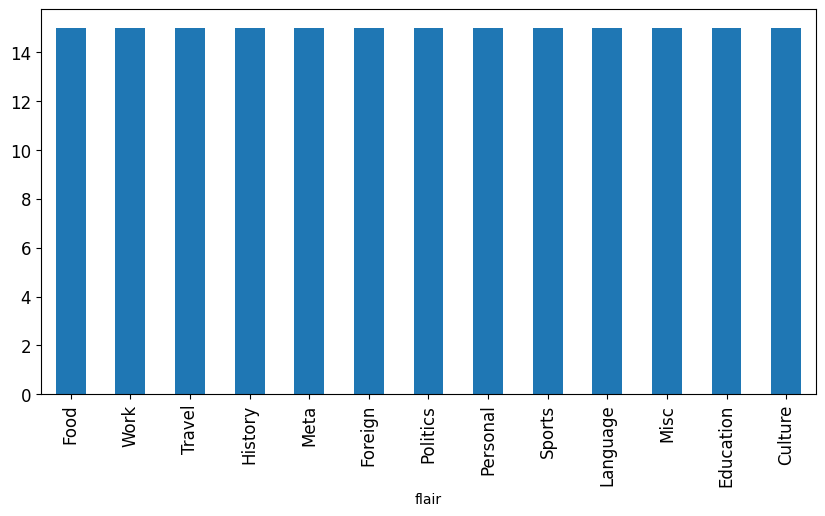

In [3]:
flairs = ['Work', 'Misc', 'Food', 'Personal', 'Meta', 'Sports', 'Travel', 'Politics', 'Culture', 'History', 'Education', 'Language', 'Foreign']

# Merging megathreads into respective flairs
for flr in flairs:
    data.flair[data.flair == flr +' [Megathread]'] = flr
    
plt.figure(figsize=(10,5))
data.flair.value_counts().plot(kind='bar', fontsize=12);

In [4]:
import cleaning

cleaning.clean_text(data, 'title')
cleaning.clean_text(data, 'body')
cleaning.clean_text(data, 'comments')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/carlesarnal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Cleaning text of title ...
DONE! 

Cleaning text of body ...
DONE! 

Cleaning text of comments ...
DONE! 



In [5]:
# Merging title and body text into a new column: content
data['content'] = data.title +' '+ data.body +' '+ data.comments +' '+ data.domain

X = data.content
y = data.flair

# Label encoding the classes (alphabetically by default)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [6]:
top_num = 10

for flair in flairs:
    all_text = ' '.join(str(word) for word in data.content[data.flair == flair].values) 
    tokens = word_tokenize(all_text)
    
    unigrams = ngrams(tokens, 1)
    unigrams = collections.Counter(unigrams).most_common(top_num)
    unigrams = [item[0][0] for item in unigrams]

    bigrams = ngrams(tokens, 2)
    bigrams = collections.Counter(bigrams).most_common(top_num)
    bigrams = [item[0][0]+' '+item[0][1] for item in bigrams]

    print(f"> {flair} \nUnigrams: {unigrams} \nBigrams: {bigrams} \n")

> Work 
Unigrams: ['€', 'work', 'day', 'year', 'net', 'pay', 'month', 'job', 'time', 'sick'] 
Bigrams: ['€ net', '€ gross', 'year experience', 'gross €', 'sick day', '€ month', 'public holiday', 'sick leave', 'day year', 'buy home'] 

> Misc 
Unigrams: ['country', 'live', 'city', 'make', 'time', 'car', 'lot', 'year', 'europe', 'speed'] 
Bigrams: ['housing crisis', 'speed limit', 'big city', 'public transport', 'year ago', 'eu country', 'rest country', 'speed cap', 'european country', 'high speed'] 

> Food 
Unigrams: ['cheese', 'eat', 'bread', 'food', 'make', 'meat', 'coffee', 'hand', 'beer', 'taste'] 
Bigrams: ['olive oil', 'leave hand', 'horse meat', 'fork leave', 'default cheese', 'hand fork', 'yellow cheese', 'cat dog', 'fork hand', 'dog cat'] 

> Personal 
Unigrams: ['english', 'german', 'french', 'fluent', 'speak', 'language', 'native', 'spanish', 'learn', 'country'] 
Bigrams: ['fluent english', 'speak english', 'native english', 'english fluent', 'english german', 'native langua

In [7]:
# Splitting data into train:test by 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

print("Distribution of classes in test set: \n", np.bincount(y_test))

# Creating the vectorizer
tfidf = TfidfVectorizer(max_features = 5000, ngram_range=(1,3), min_df=5, max_df=0.9, stop_words=cleaning.STOPWORDS )
tfidf = tfidf.fit(X_train)

with open("vectorizer.pkl", 'wb') as file:  
    pickle.dump(tfidf, file)

X_train = tfidf.transform(X_train).toarray()
print('\nTraining features shape: ',X_train.shape)

X_test = tfidf.transform(X_test).toarray()
print('Test features shape:     ',X_test.shape)

Distribution of classes in test set: 
 [6 1 4 3 1 4 2 2 4 6 2 1 3]

Training features shape:  (156, 5000)
Test features shape:      (39, 5000)


In [9]:
# Function to train the multi-class classifier

def train_classifier(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    prediction = model.predict(test_data)
    acc = round(accuracy_score(prediction, test_labels)*100, 0)
    print(f'ACCURACY = {acc} %')
    return acc, model

# Creating dictionary to record accuracy of each model
accuracies = {}

In [10]:
classifier = naive_bayes.MultinomialNB()
accuracies['Naive Bayes'], nb = train_classifier(classifier, X_train, y_train, X_test, y_test)

ACCURACY = 44.0 %


In [11]:
classifier = LogisticRegression(multi_class='multinomial', solver='sag')
accuracies['Logistic Regression'], logreg = train_classifier(classifier, X_train, y_train, X_test, y_test)

ACCURACY = 56.0 %


In [12]:
classifier = RandomForestClassifier(n_estimators = 500, min_samples_split = 10, random_state = 42)
accuracies['Random Forest'], ranfor = train_classifier(classifier, X_train, y_train, X_test, y_test)

ACCURACY = 59.0 %


In [13]:
classifier = SVC(C = 2.5, kernel = 'linear', gamma='auto', random_state=42)
accuracies['Linear SVM'], svm = train_classifier(classifier, X_train, y_train, X_test, y_test)

ACCURACY = 64.0 %


In [14]:
models_df = pd.DataFrame(accuracies.items(), columns=['Classifier', 'Accuracy %'])
models_df.sort_values(by=['Accuracy %'], ascending=False)

,Classifier,Accuracy %
3,Linear SVM,64.0
2,Random Forest,59.0
1,Logistic Regression,56.0
0,Naive Bayes,44.0


In [15]:
tsvd = TruncatedSVD(n_components = X_train.shape[1]-1, n_iter=10, random_state = 42)
tsvd = tsvd.fit(X_train)
tsvd_var_ratios  = tsvd.explained_variance_ratio_

def select_n_components(var_ratio, goal_var: float) -> int:
    
    # Initialize variance explained and num_components
    total_variance = 0.0
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total and increment components by 1
        total_variance += explained_variance
        n_components += 1
        
        # If goal level of explained variance reached
        if total_variance >= goal_var:
            break 
 
    return n_components

select_n_components(tsvd_var_ratios, 0.9)

111

In [16]:
tsvd = TruncatedSVD(n_components = 1138, n_iter=10, random_state=42)
tsvd = tsvd.fit(X_train)

with open("LSA_topics.pkl", 'wb') as file:  
    pickle.dump(tsvd, file)
    
X_train = tsvd.transform(X_train)
X_test = tsvd.transform(X_test)

print('Training features shape: ',X_train.shape)
print('Test features shape:     ',X_test.shape)

Training features shape:  (156, 156)
Test features shape:      (39, 156)


In [17]:
classifier = LogisticRegression(multi_class='multinomial', solver='sag')
accuracies['Logistic Regression'], logreg = train_classifier(classifier, X_train, y_train, X_test, y_test)

ACCURACY = 56.0 %


In [18]:
classifier = RandomForestClassifier(n_estimators = 500, min_samples_split = 10, random_state = 42)
accuracies['Random Forest'], ranfor = train_classifier(classifier, X_train, y_train, X_test, y_test)

ACCURACY = 51.0 %


In [19]:
classifier = SVC(C = 2.5, kernel = 'linear', gamma='scale', random_state=42)
accuracies['Linear SVM'], svm = train_classifier(classifier, X_train, y_train, X_test, y_test)

ACCURACY = 64.0 %


In [20]:
models_df = pd.DataFrame(accuracies.items(), columns=['Classifier', 'Accuracy %'])
models_df.drop(models_df[models_df.Classifier == 'Naive Bayes'].index, inplace=True)
models_df.sort_values(by=['Accuracy %'], ascending=False)

,Classifier,Accuracy %
3,Linear SVM,64.0
1,Logistic Regression,56.0
2,Random Forest,51.0


In [21]:
y_pred = svm.predict(X_test)
print("\nSVM Classifier results: \n")
print(classification_report(y_test, y_pred, target_names = list(encoder.classes_)))


SVM Classifier results: 

              precision    recall  f1-score   support

     Culture       0.50      0.17      0.25         6
   Education       1.00      1.00      1.00         1
        Food       1.00      1.00      1.00         4
     Foreign       0.29      0.67      0.40         3
     History       1.00      1.00      1.00         1
    Language       1.00      0.75      0.86         4
        Meta       1.00      0.50      0.67         2
        Misc       0.00      0.00      0.00         2
    Personal       0.50      0.50      0.50         4
    Politics       0.80      0.67      0.73         6
      Sports       1.00      1.00      1.00         2
      Travel       1.00      1.00      1.00         1
        Work       0.75      1.00      0.86         3

    accuracy                           0.64        39
   macro avg       0.76      0.71      0.71        39
weighted avg       0.72      0.64      0.65        39



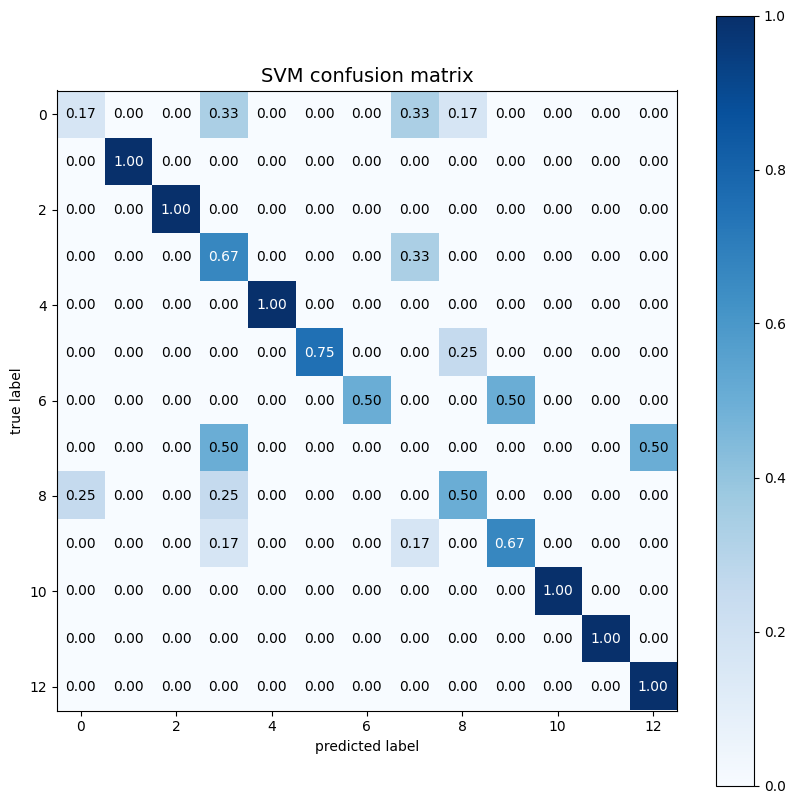

In [22]:
# CREATING THE CONFUSION MATRIX
fig, ax = plot_confusion_matrix(conf_mat = confusion_matrix(y_test, y_pred),
                                colorbar = True,
                                show_absolute = False,
                                show_normed = True,
                                figsize = (10,10))
plt.title("SVM confusion matrix", fontsize=14)
plt.show()

In [23]:
# Saving the best model as pickle file which would be used in website
with open("reddit_classifier.pkl", 'wb') as file:  
    pickle.dump(svm, file)